In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
from getRefXSecs import getXSecFor
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('EWino_scanRandom.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.

#### Add c*tau column for charginos

In [4]:
dataDF['ctau.1000024'] = 1.967e-16/dataDF['width.1000024']

### Add ratio of total cross-section to wino cross-sections

In [5]:
pids = [[-1000024,1000024],[1000023,1000024],[-1000024,1000023]]
ratio = []
for index,row in dataDF.iterrows():    
    xsecRefSum = 0.0
    xsecSum = 0.0
    for pidpair in pids:
        mass1 = row['mass.%i'%abs(pidpair[0])] 
        mass2 = row['mass.%i'%abs(pidpair[1])] 
        mass = (mass1+mass2)/2.
        xsecRef = max(0,1000*getXSecFor(pidpair[0],pidpair[1],mass,13.0,'wino'))
        xsecRefSum += xsecRef
            
        xsecLabel = 'xsec13TeV(fb).%i_%i' %(pidpair[0],pidpair[1])
        try:
            xsec = row[xsecLabel]
        except:
            xsec = 0.0
        xsecSum += xsec
    if xsecRefSum > 0.0:
        ratio.append(xsecSum/xsecRefSum)    
    else:
        ratio.append(0.0)

In [6]:
dataDF['xsecRatio'] = ratio

### Get points excluded and allowed

In [8]:
excluded = dataDF[dataDF['excluded'] == True]
allowed = dataDF[dataDF['excluded'] == False]
print('Total number of points = %i' %len(dataDF))
print('Total excluded = %i'%(len(excluded)))
print('Total allowed = %i'%(len(allowed)))

Total number of points = 96669
Total excluded = 7348
Total allowed = 89321


In [21]:
dataFiltered = allowed[(allowed['mass.1000024']-allowed['mass.1000022'] < 90.)
        & (abs(allowed['mass.1000022']-150.) < 30.)
        & (abs(allowed['mass.1000024']-175.) < 25.)
        & (abs(allowed['mass.1000024']-allowed['mass.1000023']) < 1.0)                       
        & (allowed['ExptRes.result0.r']/allowed['xsecRatio'] < 0.9)]
dataFiltered[['mass.1000024','mass.1000023','mass.1000022','ExptRes.result0.r','xsecRatio','filename']]

,mass.1000024,mass.1000023,mass.1000022,ExptRes.result0.r,xsecRatio,filename
93317,185.298651,185.145625,152.494264,0.697072,0.874663,ew_ry38c0f4.slha
13701,198.294454,198.138001,161.980139,0.413565,0.649503,ew_z2ntz8dn.slha
17982,170.037550,170.038370,158.518549,0.014518,0.213198,ew_01aymkqg.slha
69476,161.733211,161.626239,146.580542,0.010574,0.209007,ew_ube7jehj.slha
30897,159.578378,159.972930,150.064263,0.009680,0.222468,ew__n5_ipn3.slha
7239,174.276828,174.217879,160.661571,0.009376,0.218007,ew_n8b4pa16.slha
92297,184.139464,184.055414,167.846997,0.009023,0.209784,ew_8hc5sqqr.slha
14343,192.686917,192.625235,177.182288,0.007247,0.209279,ew_ikrzwzki.slha
43256,166.005865,166.036731,157.685118,0.006953,0.208544,ew_sv4c653b.slha
9695,185.678940,185.669717,175.028521,0.005841,0.210219,ew_evjqp_8i.slha


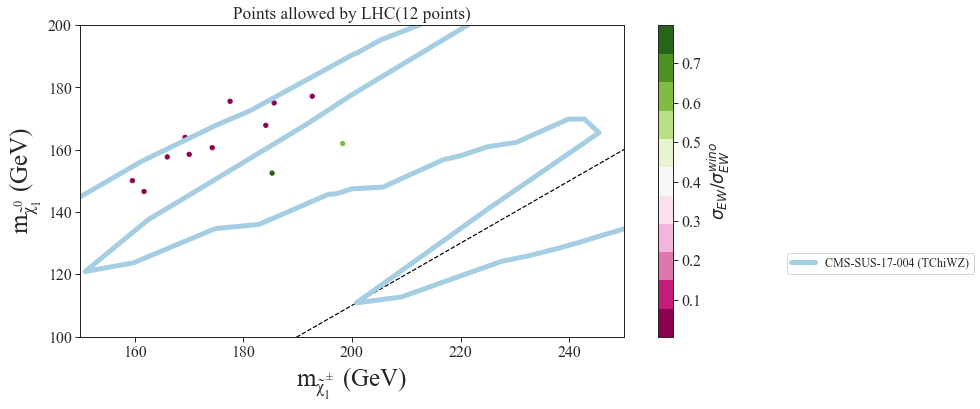

In [24]:
plt.figure(figsize=(14,6))
excCurves = {}
excCurves['CMS-SUS-17-004 (TChiWZ)'] =  np.genfromtxt('../EWino/data/CMS_SUS_17_004_TChiWZ_obs.csv', 
                                                      delimiter=',')
colorDict = dict(zip(excCurves.keys(),sns.color_palette("Paired",len(excCurves))))

x = dataFiltered['mass.1000024']
y = dataFiltered['mass.1000022']
# z = dataFiltered['ExptRes.result0.r']
z = dataFiltered['ExptRes.result0.r']/dataFiltered['xsecRatio']
cm = plt.cm.get_cmap('Greys')
cm = plt.cm.get_cmap('PiYG', 11) 

plt.scatter(x,y,c=z,s=20,cmap=cm,vmin=z.min(),vmax=z.max())

plt.plot([90,500],[0,410],linestyle='--',c='black')


for ana in excCurves:
    curve = excCurves[ana]
    color = colorDict[ana]
    plt.plot(curve[:,0],curve[:,1],linewidth=5,linestyle='-',color=color,label=ana)
        

lgd = plt.legend(loc=(1.3,0.2), framealpha=1.,fontsize=12)

plt.ylim(100,200)
plt.xlim(150,250)
plt.xlabel(r'$\mathregular{m_{\tilde{\chi}_1^\pm}}$ (GeV)',fontsize = 25)
plt.ylabel(r'$\mathregular{m_{\tilde{\chi}_1^0}}$ (GeV)',fontsize = 25)
plt.title("Points allowed by LHC(%i points)" %len(x))
plt.colorbar(label = r'$\sigma_{EW}/\sigma_{EW}^{wino}$')
plt.tight_layout()
plt.show()

In [22]:
dataFiltered['ExptRes.result0.r']/dataFiltered['xsecRatio']

91449    3.782430
25285    2.791507
81935    2.795434
20299    2.237624
1626     0.930062
91795    0.079771
45489    0.048397
42409    0.027737
6672     0.026281
15332    0.024988
25242    0.023198
19418    0.018163
77405    0.017890
dtype: float64

In [25]:
row = allowed.loc[8885]

KeyError: 8885

In [15]:
row['mass.1000024'],row['mass.1000022'],row['filename']

(134.920247, 50.2767346, 'ew_448sx8j9.slha')

In [16]:
print(row['ExptRes.result0.r'],row['ExptRes.result0.AnalysisID'])

0.360776 ATLAS-SUSY-2013-11


In [17]:
print(row['xsec13TeV(fb).1000023_1000024'],row['xsec13TeV(fb).-1000024_1000023'])
print('Total = ',row['xsec13TeV(fb).1000023_1000024']+row['xsec13TeV(fb).-1000024_1000023'])

3091.93008 1766.92171
Total =  4858.851790000001


In [14]:
#Cross-sections from Prospino:
# (1000023_1000024): LO = 5.64, NLO = 6.33
# (-1000024_1000023): LO = 1.88, NLO = 2.27
# Total: LO = 7.52, NLO = 8.6 (K = 1.14)

#Cross-sections from Pythia6:
# (1000023_1000024): LO = 5.958
# (-1000024_1000023): LO = 1.962
# Total: LO = 7.91

#Cross-sections for winos (LHC SUSY Xsec group):
# (1000023_1000024): NLO+NLL = 6.99
# (-1000024_1000023): NLO+NLL = 2.52
# Total: NLO+NLL = 9.51


